In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.svm import SVR

import matplotlib.pyplot as plt

import torch.optim as optim
import torch.nn as nn
import torch

import time
import pandas as pd
import numpy as np

url = 'https://raw.githubusercontent.com/HeedfulMoss/ECGR_4105_Intro_ML/main/Homework/Homework_3/cancer.csv'
df = pd.read_csv(url)

df.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Preprocessing

In [ ]:
# Drop 'id' column if present and map 'diagnosis' to binary labels
df = df.drop(columns=['id'], errors='ignore')
df['diagnosis'] = df['diagnosis'].map({'M': 1, 'B': 0})

y = df.pop('diagnosis').values.reshape(-1, 1)
x = df.values

Splitting Training and Validation Set for a Fully Connected Neural Network.

In [ ]:
# Standardize data
scaler_x = StandardScaler()
x_n = torch.tensor(scaler_x.fit_transform(x), dtype=torch.float32)
y_n = torch.tensor(y, dtype=torch.float32)

# Split into training and validation sets
x_train, x_val, y_train, y_val = train_test_split(x_n, y_n, test_size=0.2, random_state=42)

Training Loop Structure

In [ ]:
# Training Function
def training(epochs, optimizer, model, loss_fn, x_train, x_val, y_train, y_val):
    train_losses, val_losses = [], []
    start_time = time.time()

    for epoch in range(1, epochs + 1):
        model.train()
        y_pred_train = model(x_train)
        train_loss = loss_fn(y_pred_train, y_train)

        model.eval()
        with torch.no_grad():
            y_pred_val = model(x_val)
            val_loss = loss_fn(y_pred_val, y_val)

        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()

        train_losses.append(train_loss.item())
        val_losses.append(val_loss.item())

        if epoch % 1000 == 0:
            elapsed_time = time.time() - start_time
            with torch.no_grad():
                predictions = torch.round(y_pred_val)
                accuracy = accuracy_score(y_val.numpy(), predictions.numpy())
            print(f"Epoch {epoch}: Training Time = {elapsed_time:.2f}s, Training Loss = {train_loss.item():.4f}, Accuracy = {accuracy:.4f}")

    total_training_time = time.time() - start_time
    return train_losses, val_losses, total_training_time

2a. SGD Optimized Linear Model with 1 hidden layer


In [ ]:
print("\nModel with 1 Hidden Layer")
seq_model_1 = nn.Sequential(
    nn.Linear(x_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(seq_model_1.parameters(), lr=1e-3)
loss_fn = nn.BCELoss()  # Binary Cross-Entropy Loss

train_losses_1, val_losses_1, training_time_1 = training(
    epochs=5000,
    optimizer=optimizer,
    model=seq_model_1,
    loss_fn=loss_fn,
    x_train=x_train,
    x_val=x_val,
    y_train=y_train,
    y_val=y_val
)


Model with 1 Hidden Layer
Epoch 1000: Training Time = 4.79s, Training Loss = 0.4464, Accuracy = 0.9649
Epoch 2000: Training Time = 7.15s, Training Loss = 0.2947, Accuracy = 0.9649
Epoch 3000: Training Time = 9.42s, Training Loss = 0.2189, Accuracy = 0.9649
Epoch 4000: Training Time = 10.81s, Training Loss = 0.1771, Accuracy = 0.9737
Epoch 5000: Training Time = 11.72s, Training Loss = 0.1513, Accuracy = 0.9737


2b. SGD Optimized Linear Model with two more hidden layers


In [ ]:
print("\nModel with two more Hidden Layers")
seq_model_3 = nn.Sequential(
    nn.Linear(x_train.shape[1], 32),
    nn.ReLU(),
    nn.Linear(32, 64),
    nn.ReLU(),
    nn.Linear(64, 16),
    nn.ReLU(),
    nn.Linear(16, 1),
    nn.Sigmoid()
)

optimizer = optim.SGD(seq_model_3.parameters(), lr=1e-3)

train_losses_3, val_losses_3, training_time_3 = training(
    epochs=5000,
    optimizer=optimizer,
    model=seq_model_3,
    loss_fn=loss_fn,
    x_train=x_train,
    x_val=x_val,
    y_train=y_train,
    y_val=y_val
)


Model with 3 Hidden Layers
Epoch 1000: Training Time = 2.03s, Training Loss = 0.6445, Accuracy = 0.6228
Epoch 2000: Training Time = 3.94s, Training Loss = 0.6062, Accuracy = 0.6930
Epoch 3000: Training Time = 5.34s, Training Loss = 0.5336, Accuracy = 0.8246
Epoch 4000: Training Time = 6.75s, Training Loss = 0.4160, Accuracy = 0.9474
Epoch 5000: Training Time = 8.16s, Training Loss = 0.3011, Accuracy = 0.9737


Evaluation


Evaluating 1 Hidden Layer Model:
Accuracy: 0.9737

              precision    recall  f1-score   support

      Benign       0.97      0.99      0.98        71
   Malignant       0.98      0.95      0.96        43

    accuracy                           0.97       114
   macro avg       0.97      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114


Evaluating 3 Hidden Layer Model:
Accuracy: 0.9737

              precision    recall  f1-score   support

      Benign       0.96      1.00      0.98        71
   Malignant       1.00      0.93      0.96        43

    accuracy                           0.97       114
   macro avg       0.98      0.97      0.97       114
weighted avg       0.97      0.97      0.97       114



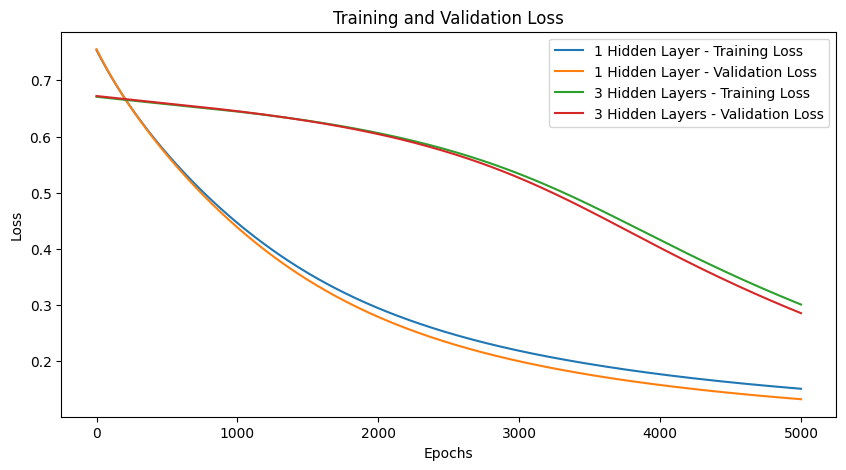

In [ ]:
def evaluate(model, x_val, y_val):
    model.eval()
    with torch.no_grad():
        y_pred = model(x_val)
        predictions = torch.round(y_pred)
    accuracy = accuracy_score(y_val.numpy(), predictions.numpy())
    report = classification_report(y_val.numpy(), predictions.numpy(), target_names=['Benign', 'Malignant'])
    return accuracy, report

# Evaluation
print("\nEvaluating 1 Hidden Layer Model:")
accuracy_1, report_1 = evaluate(seq_model_1, x_val, y_val)
print(f"Accuracy: {accuracy_1:.4f}\n")
print(report_1)

print("\nEvaluating 3 Hidden Layer Model:")
accuracy_3, report_3 = evaluate(seq_model_3, x_val, y_val)
print(f"Accuracy: {accuracy_3:.4f}\n")
print(report_3)

# Plot Losses
plt.figure(figsize=(10, 5))
plt.plot(train_losses_1, label='1 Hidden Layer - Training Loss')
plt.plot(val_losses_1, label='1 Hidden Layer - Validation Loss')
plt.plot(train_losses_3, label='3 Hidden Layers - Training Loss')
plt.plot(val_losses_3, label='3 Hidden Layers - Validation Loss')
plt.legend()
plt.title("Training and Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.show()